<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v15_gradientNorms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v15: Gradient Norms
Firstly, my latest literature survey has found that it's very common to use the frobenius norm of gradient tensors to measure their magnitude. Secondly, I've since realised that when collecting stats per-epoch, I need to compute the _mean_ or _sum_ of gradients over the entire epoch, rather than blindly picking the latest value.

Together, that could produce far smoother and more meaningful results when plotting 1) per-epoch stats, 2) model-wide stats of magnitudes (per-epoch or per-step), and 3) comparing layer magnitudes.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
#!cd repo && git checkout 57a6d83
!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

Cloning into 'repo'...
remote: Enumerating objects: 1112, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 1112 (delta 79), reused 77 (delta 38), pack-reused 977 (from 1)
Receiving objects: 100% (1112/1112), 77.33 MiB | 9.07 MiB/s, done.
Resolving deltas: 100% (676/676), done.
Already up to date.


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [2]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basics


In [4]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

class TimingCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self._start = None
    self._epochs = None
    self.total = None
    self.per_epoch = None

  def on_epoch_begin(self, epoch, logs=None):
    if epoch == 1:
      self._start = tf.timestamp()
    self._epochs = epoch-1

  def on_train_end(self, logs=None):
    self.total = (tf.timestamp() - self._start).numpy()
    self.per_epoch = self.total / (self._epochs)

# Basic model
First, we'll start with a basic data collection routine to confirm how we can most efficiently aggregate sum or mean values over the course of an epoch.

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


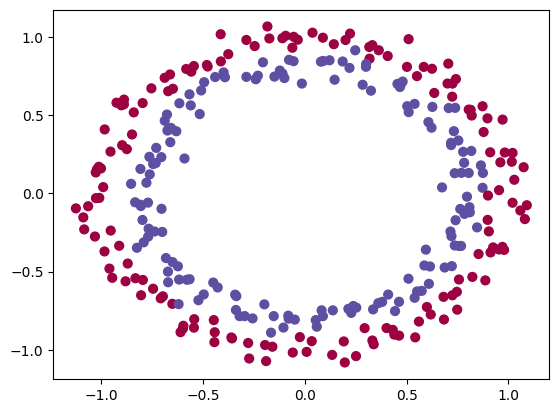

In [5]:
train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [22]:
# Timings CPU - on binary classification model:
#  - 45ms - baseline
#  - 65ms - naive accumulator = accumalotor + value, with minimal pre-initialisation, no @tf.function
#  - 65ms - naive accumulator = accumalotor + value, with minimal pre-initialisation, with @tf.function
#  - 77ms - tf.Variable accumulator with pre-initialisation, no @tf.function
#  - 77ms - tf.Variable accumulator with pre-initialisation, with @tf.function
# Timings GPU - on MNIST classification model (32000 samples, batch-size 64):
#  - 3700ms (5.5ms/step) - baseline
#  - 4700ms (7.0ms/step) - naive accumulator = accumalotor + value, with minimal pre-initialisation, without @tf.function
#  - 5400ms (6.8ms/step) - naive accumulator = accumalotor + value, with minimal pre-initialisation, with @tf.function
#  - 5400ms (7.2ms/step) - tf.Variable accumulator with pre-initialisation, without @tf.function
#  - 3770ms (6.5ms/step) - tf.Variable accumulator with pre-initialisation, with @tf.function
#  - note: the supplied gradients are GPU-bound. So are the TF value and tf.Variable() accumulators.
class MyCallback1(tot.BaseGradientCallback):
  def __init__(self):
    super().__init__()
    self._accumulators = None
    self._norms = []  # list (by iteration) of list (by variable) of scalar norms of gradients

  @property
  def norms(self):
    return np.stack(self._norms, axis=0)

  def on_epoch_begin(self, epoch):
    if self._accumulators is not None:
      self._accumulators = [None] * len(self._accumulators)

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    self._norms.append([tf.norm(tensor) if tensor is not None else None for tensor in self._accumulators])

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    self._init_accumulators(gradients)
    self._accumulators = self._accumulate(self._accumulators, gradients)
    if batch == 0:
      print(f"gradients: {gradients[0].device}, accumulators: {self._accumulators[0].device}")

  def _init_accumulators(self, gradients):
    if self._accumulators is None:
      self._accumulators = [None] * len(gradients)

  @tf.function
  def _accumulate(self, accumulators, values):
    res = []
    for accumulator, value in zip(accumulators, values):
      if value is not None:
        if accumulator is None:
          accumulator = value
        else:
          accumulator += value
      else:
        accumulator = None
      res.append(accumulator)
    return res

class MyCallback2(tot.BaseGradientCallback):
  def __init__(self):
    super().__init__()
    self._accumulators = None
    self._norms = []  # list (by iteration) of list (by variable) of scalar norms of gradients

  @property
  def norms(self):
    return np.stack(self._norms, axis=0)

  def on_epoch_begin(self, epoch):
    if self._accumulators is not None:
      for a in self._accumulators:
        a.assign(tf.zeros(a.shape))

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    self._norms.append([tf.norm(tensor) if tensor is not None else None for tensor in self._accumulators])

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    # init
    if self._accumulators is None:
      self._accumulators = [tf.Variable(tf.zeros_like(g), dtype=g.dtype) for g in gradients]

    # accumulate
    self._accumulate(self._accumulators, gradients)

  @tf.function
  def _accumulate(self, accumulators, values):
    for accumulator, value in zip(accumulators, values):
      if value is not None:
        accumulator.assign_add(value)

reload(tot)
tf.config.run_functions_eagerly(False)

cb = MyCallback1()
timing = TimingCallback()
#model = binary_classification_model('he_normal')
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
#train_X, train_Y, _, _ = binary_classification_dataset()
#dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(32000).batch(64)
start = tf.timestamp()
#history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(), cb, timing])
history = tot.fit(model, dataset, epochs=10, callbacks=[tot.HistoryStats(), cb , timing])
duration = (tf.timestamp() - start).numpy()
print(f"Total training time: {duration:.2f} secs. Average: {timing.per_epoch*1000:.2f}ms/epoch")


Epoch 1/10
  1/500 ━━━━━━━━━━━━━━━━━━━━ 12:03 1s/step - accuracy: 0.0625 - loss: 2.3053gradients: /job:localhost/replica:0/task:0/device:GPU:0, accumulators: /job:localhost/replica:0/task:0/device:GPU:0
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7924 - loss: 0.6521
Epoch 2/10
  1/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0740gradients: /job:localhost/replica:0/task:0/device:GPU:0, accumulators: /job:localhost/replica:0/task:0/device:GPU:0
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9671 - loss: 0.1103
Epoch 3/10
  1/500 ━━━━━━━━━━━━━━━━━━━━ 16:34 2s/step - accuracy: 0.9844 - loss: 0.0479gradients: /job:localhost/replica:0/task:0/device:GPU:0, accumulators: /job:localhost/replica:0/task:0/device:GPU:0
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9796 - loss: 0.0674
Epoch 4/10
  1/500 ━━━━━━━━━━━━━━━━━━━━ 15:24 2s/step - accuracy: 0.9844 - loss: 0.0394gradients: /job:localhost/replica:0/task:0/device:GPU:0, accumulators: /job:local

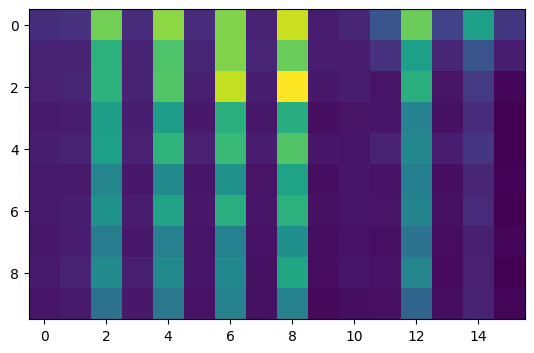

In [21]:
plt.imshow(cb.norms)

In [19]:
a = tf.zeros((500,100))
a.device

'/job:localhost/replica:0/task:0/device:GPU:0'

In [26]:
reload(tot)
tot.reload_safe_check(tot.GradientHistoryCallback())

True

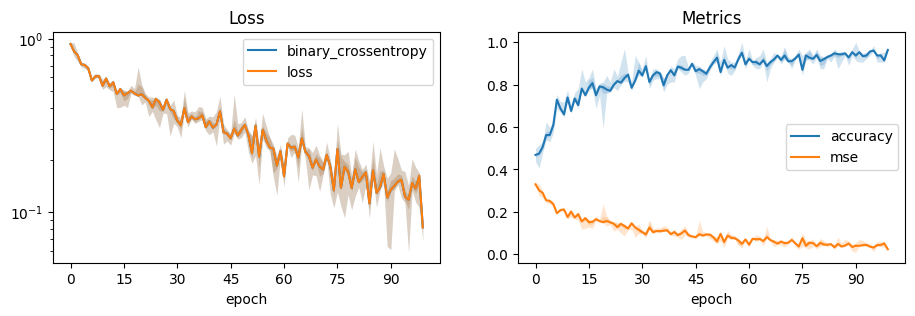

In [ ]:
tot.plot_train_history(history)